This notebook contains code corresponding to the interpolated quantile graphs. Pick a dataset and an attribute and the code will generate the interpolated quantiles of the latent wrt to the attribute and the median of the other attributes

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import warnings
import matplotlib.pyplot as plt
import shap

warnings.filterwarnings("ignore", category=UserWarning) # Prevents Tanh warning messages 

Scaler = StandardScaler()
shap.initjs()

In [2]:
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, ditch_head=True):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        X.append(point)
        Y.append(float(all_columns[target_column]))
    X_arr = np.asarray(X)
    X_unscaled = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = 0
    Y_arr_binary = np.where(Y_arr<=thresh,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, X_unscaled



In [3]:
torch.manual_seed(111)

class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,10)
        self.l3 = nn.Linear(10,9)
    
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x

In [4]:
# Loss and Accuracy Computation functions

def cumLaplaceDistribution(y_pred,mean,standard_deviation,all_qs):
    term1 = ((1-all_qs) * (y_pred - mean))/standard_deviation
    term1.clamp_(max = 0) # Prevents NaN - Only one of term 1 or 2 is used, whichever is -ve
    lesser_term = all_qs * torch.exp(term1)
    term2 = (-1.0 * all_qs * (y_pred - mean))/standard_deviation
    term2.clamp_(max = 0) # Again, Prevents NaN
    greater_term = 1 - ((1-all_qs) * torch.exp(term2))
    mean_tensor = torch.ones_like(mean)
    y_mask = torch.div(y_pred,mean_tensor)
    y_mask[y_pred >= mean] = 1.0
    y_mask[y_pred < mean] = 0.0
    return ((1 - y_mask) * lesser_term )+  (y_mask * greater_term)


def logLikelihoodLoss(y_true,y_pred,mean,standard_deviation,all_qs):
    new_pred = y_pred
    prob = cumLaplaceDistribution(0.0,mean = new_pred,
                                  standard_deviation = standard_deviation,all_qs = all_qs)
    prob.clamp_(min = 1e-7,max = 1 - 1e-7)
    if_one = y_true * torch.log(1 - prob)
    if_zero = (1 - y_true) * torch.log(prob)
    final_loss = - 1 * torch.mean(if_one + if_zero)
    return final_loss

def customLoss(y_true, y_pred, mean, standard_deviation, all_qs, penalty):
    ind_losses = []
    for i,j in enumerate(all_qs):
        single_quantile_loss = logLikelihoodLoss(y_true[:,0],y_pred[:,i] ,
                                                 mean, standard_deviation, j)
        ind_losses.append(single_quantile_loss)
    zero = torch.Tensor([0]).to(device)
    dummy1 = y_pred[:,1:] - y_pred[:,:-1]
    dummy2 = penalty * torch.mean(torch.max(zero,-1.0 * dummy1))
    total_loss  = torch.mean(torch.stack(ind_losses)) +dummy2
    return total_loss

def customTestPred(y_pred,mean,standard_deviation,all_qs,batch_size = 1):
    acc = []
    cdfs = []
    val = (y_pred - mean)/standard_deviation 
    
    for xx in range(batch_size):
        if(y_pred < mean[xx]):
            lesser_term = all_qs * torch.exp((1.0 - all_qs) * torch.tensor(val[xx], dtype=torch.double)) 
            # Typecast above needed for some versions of torch
            lesser_term  = 1 - lesser_term
            cdfs.append(lesser_term.item())
            if(lesser_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
        
        elif(y_pred >= mean[xx]):
            greater_term = 1.0 - ((1.0-all_qs) * torch.exp(-1.0 * all_qs * torch.tensor(val[xx], dtype=torch.double)))
            # Typecast above needed for some versions of torch
            greater_term = 1 - greater_term
            cdfs.append(greater_term.item())
            if(greater_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
    return torch.Tensor(acc).to(device).reshape(-1,1),torch.Tensor(cdfs).to(device).reshape(-1,1)

def acc_tests(test_preds,test_labels):
    test_preds = np.array(test_preds).reshape(-1,1)
    test_labels = np.array(test_labels).reshape(-1,1)
    cdfs_acc,_ = customTestPred(0,test_preds,standard_deviation = 1,all_qs = torch.Tensor([0.5]),
                                batch_size = test_preds.shape[0])

    count = 0
    for i,j in zip(cdfs_acc,test_labels):
        if(i.item() == j[0]):
            count += 1
    return count/test_labels.shape[0]

In [5]:
# Training and Testing Methods

def train(model,loader,epochs, verbose=False):
    train_preds_Q = []
    train_labels = []
    model.train()
    
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        op_qs = model(inputs)
        lossQ = customLoss(labels.reshape(-1,1),op_qs, mean_is,std_is,all_qs,penalty)
        lossQ.backward()
        optimizer.step()
        
        for lag in op_qs[:,4].detach().reshape(-1,1):
            train_preds_Q.append(lag.item())
        for lag in labels.reshape(-1,1):
            train_labels.append(lag.item())
            
    acc_is_Q = acc_tests(train_preds_Q,train_labels)
    
    if verbose:
        print("[%d/%d] Train Acc Q : %f "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

def test(model,loader,epochs,verbose=False):
    model.eval()
    test_preds_Q = []
    test_preds_bce = []
    test_labels = []
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op_qs = model(inputs)
            
            for lag in op_qs[:,4].detach().reshape(-1,1):
                test_preds_Q.append(lag.item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
                
    acc_is_Q = acc_tests(test_preds_Q,test_labels)
    
    if verbose:
        print("[%d/%d] Test Acc Q : %f  "%(epochs,total_epochs,acc_is_Q))
    return acc_is_Q

def quantileCDF(x, tau=0.5):
    if x>0:
        return 1 - tau*np.exp((tau-1)*x)
    else:
        return (1 - tau)*np.exp(tau*x)

In [6]:
def kernel(u):
    return np.exp(-0.5*(u**2))/np.sqrt((2*np.pi))

def smoothed_quantile(tau, available_tau, available_quantiles,h=0.1):
    result = []
    for point in range(len(available_quantiles[0])):
        numerator = 0
        denominator = 0
        for t in range(len(available_tau)):
            weight = kernel((tau-available_tau[t])/h)/h
            numerator += weight*available_quantiles[t][point]
            denominator += weight
        result.append(numerator/denominator)  
    return result

def interpolated_mean_prob(sample, model):
    total = 0
    result = []
    sample_tensor = torch.Tensor(sample)
    model_ops = model(sample_tensor)
    available_quantiles = [0.1,0.2,0.3,0.4,0.5,
                          0.6,0.7,0.8,0.9]
    for op in model_ops.detach():
        total = 0
        available = []
        for q in range(9):
            available.append([op[q].item()])
        for i in range(1,20):
            total += smoothed_quantile(0.05*i,available_quantiles,available)[0]
        total/=19
        #prob = quantileCDF(total)
        #result.append(prob)
        result.append(total)
    return np.array(result)

In [7]:
batch_is = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic=True
print("Torch Device:",device)
torch.set_default_dtype(torch.double)

Torch Device: cpu


In [8]:
# Control the dataset here

dataset = '../Datasets/Classification/heart.csv'
x_cols = list(range(13))
y_col = 13

attribute_index = 7 # This controls which attribute is allowed to vary
attribute_name = "Max Heart Rate" # Name of the attribute, used in the plots
latent_name = "Heart Disease" # Name of the function, used in the plots
# The other attributes are replaced by the median value of the attribute

total_epochs = 20

In [9]:
X_train,X_val,y_train,y_val, data_Y, data_X_scaled, data_X_unscaled = create_xy(dataset, x_cols, y_col, ",", 0.2)
shap_x_train = X_train.copy()
shap_x_val = X_val.copy()
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =batch_is,pin_memory=True,shuffle = False,num_workers = 1)

In [10]:
indim = X_train.shape[1]
model = Network(indim)
model = model.to(device)

In [11]:
lr_is = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0

In [12]:
for i in range(total_epochs):
    print("Epoch:",str(i+1))
    acc_train = train(model,train_loader,i)
    acc_test = test( model,test_loader,i)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


In [13]:
new_scaler = StandardScaler()
new_scaler.fit(data_X_unscaled)

col_index = attribute_index
attribute_array = np.arange(min(data_X_unscaled[:,col_index]), max(data_X_unscaled[:,col_index]),1)

test_inputs  = []
med_values_left = []
med_values_right = []

for i in range(len(data_X_unscaled[0])):
    if i<col_index:
        med_values_left.append(np.mean(data_X_unscaled[:,i]))
    elif i>col_index:
        med_values_right.append(np.mean(data_X_unscaled[:,i]))

for i in range(len(attribute_array)):
    test_inputs.append(np.concatenate([med_values_left,attribute_array[i],med_values_right], axis=None))

scaled_input = new_scaler.transform(test_inputs)
X_tens = torch.Tensor(scaled_input)
y_tens = torch.Tensor([0]*len(scaled_input)) # irrelevant 

func_dataset = data_utils.TensorDataset(X_tens, y_tens)
func_loader = data_utils.DataLoader(func_dataset, batch_size =1024, pin_memory=True,shuffle=False,num_workers = 1)

In [14]:
model.eval()
outputs = [[] for i in range(9)]
probs = [[] for i in range(9)]
avg = []
with torch.no_grad():
    for i,j in func_loader:
        inputs,labels = i.to(device),j.to(device)
        op_qs = model(inputs)
        for itemset in op_qs.detach():
            total = 0
            for q in range(9):
                val = itemset[q].item()
                total+=val
                outputs[q].append(val)
                probs[q].append(quantileCDF(val))
            avg.append(total/9)

In [15]:
new_tau = []
for i in range(1,20):
    new_tau.append(i*0.05)
available_tau = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
interpolated = []
for i in new_tau:
    interpolated.append(smoothed_quantile(i, available_tau, outputs))

In [16]:
print("Median of features")
for i in med_values_left:
    print(i)
print("Varying Feature:", attribute_name)
for i in med_values_right:
    print(i)

Median of features
54.366336633663366
0.6831683168316832
0.966996699669967
131.62376237623764
246.26402640264027
0.1485148514851485
0.528052805280528
Varying Feature: Max Heart Rate
0.32673267326732675
1.0396039603960396
1.3993399339933994
0.7293729372937293
2.3135313531353137


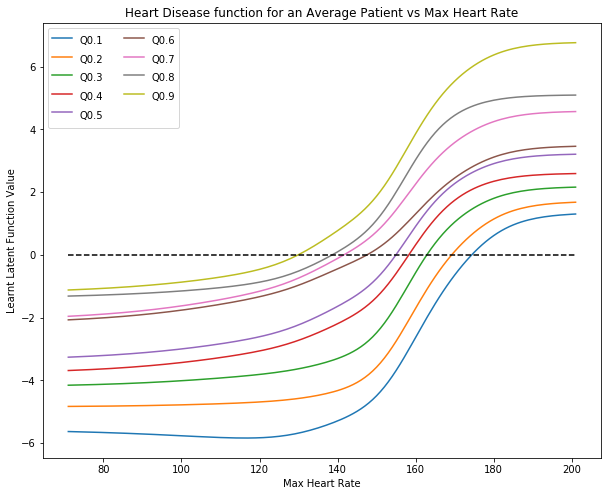

In [17]:
plt.figure(figsize=(10,8))
plt.title(latent_name + " function for an Average Patient vs " + attribute_name)
for i in range(9):
    plt.plot(attribute_array, outputs[i],label="Q0."+str(i+1))
plt.plot([min(attribute_array), max(attribute_array)],[0,0], linestyle="dashed", c="k")
plt.ylabel("Learnt Latent Function Value")
plt.xlabel(attribute_name)
plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()


Interpolated Quantiles


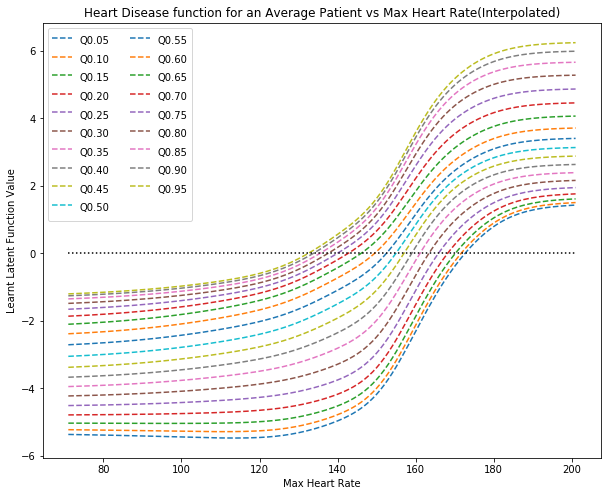

In [18]:
print("Interpolated Quantiles")

plt.figure(figsize=(10,8))
plt.title(latent_name + " function for an Average Patient vs "+attribute_name + "(Interpolated)")
for i in range(19):
    plt.plot(attribute_array, interpolated[i],label="Q{:.2f}".format(new_tau[i]), linestyle="dashed")
plt.plot([min(attribute_array), max(attribute_array)],[0,0], linestyle="dotted", c="k")
plt.ylabel("Learnt Latent Function Value")
plt.xlabel(attribute_name)
plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()

Mean as per Area under curve 1.594
Mean as per arithmetic mean 1.772



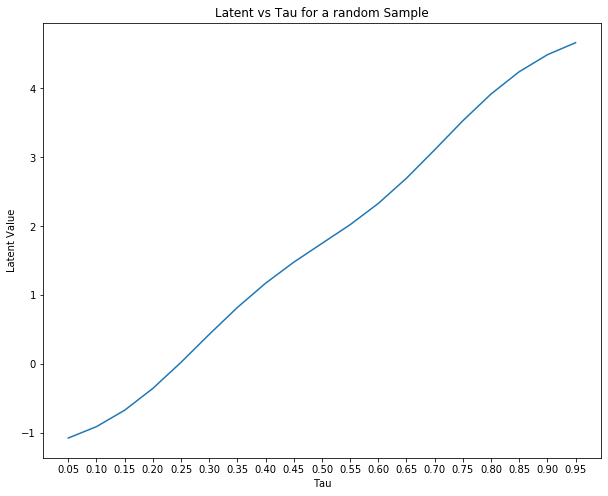

In [19]:
arith_mean = 0
random_point = np.random.randint(0,len(interpolated[0]))
latent_values = []
plt.figure(figsize=(10,8))
for i in range(len(interpolated)):
    val = interpolated[i][random_point]
    latent_values.append(val)
    arith_mean += val
arith_mean /= 19
a1 = auc(new_tau, latent_values)
print("Mean as per Area under curve {:.3f}".format(a1))
print("Mean as per arithmetic mean {:.3f}".format(arith_mean))
print()
plt.title("Latent vs Tau for a random Sample")
plt.plot(new_tau, latent_values)
plt.xticks(new_tau)
plt.ylabel("Latent Value")
plt.xlabel("Tau")
plt.show()

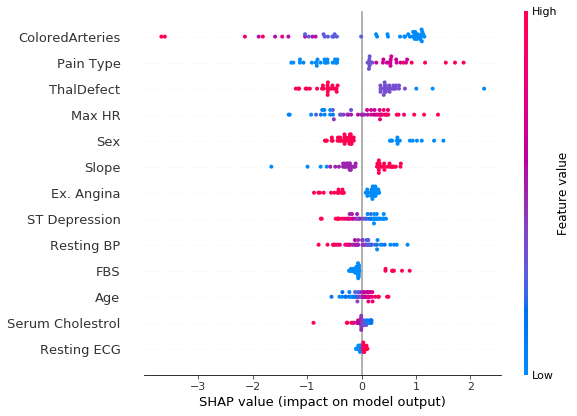

In [21]:
import pandas as pd
f = lambda x: interpolated_mean_prob(x,model)

hr_col_names = ["Age","Sex","Pain Type","Resting BP", "Serum Cholestrol",
               "FBS", "Resting ECG", "Max HR", "Ex. Angina", "ST Depression","Slope","ColoredArteries","ThalDefect"]

sample_shap_val = shap_x_val[:50]
df_dict ={}
col_headers = []
for i in range(len(shap_x_val[0])):
    #df_dict["Col"+str(i+1)] = sample_shap_val[:,i]
    df_dict[hr_col_names[i]] = sample_shap_val[:,i]
    


shap_dset = pd.DataFrame(df_dict)
    

explainer = shap.KernelExplainer(f, shap_dset)
shap_values = explainer.shap_values(shap_dset, n_samples=len(shap_dset))
shap.summary_plot(shap_values,shap_dset)